In [1]:
from types import MethodType
from cirkit.symbolic.circuit import Circuit
from cirkit.symbolic.layers import GaussianLayer, SumLayer

def build_circuit_one_sum(
    self,
    *,
    input_factory,        # like lambda scope, n: GaussianLayer(scope, n)
    sum_weight_factory,   # your ParameterFactory for the SumLayer
    num_input_units: int, # # of outputs per Gaussian leaf
    num_sum_units: int,   # # of mixtures in the one SumLayer
) -> Circuit:
    # 1) Find all the leaves in the region graph:
    leaves = [node for node in self.topological_ordering()
              if not self.region_inputs(node)]
    
    layers = []
    in_layers = {}
    
    # 2) Build one GaussianLayer per leaf
    gaussians = []
    for leaf in leaves:
        gauss = input_factory(leaf.scope, num_input_units)
        layers.append(gauss)
        gaussians.append(gauss)
    
    # 3) Build *one* SumLayer mixing them all
    sum_layer = SumLayer(
        num_input_units=num_input_units,
        num_output_units=num_sum_units,
        arity=len(gaussians),
        weight_factory=sum_weight_factory,
    )
    layers.append(sum_layer)
    in_layers[sum_layer] = gaussians
    
    # 4) Return a circuit whose only output is that top‐sum
    print(layers,"---------------\n\n\n",in_layers,"---------------\n\n\n",[sum_layer])
    return Circuit(layers, in_layers, outputs=[sum_layer])


In [2]:
import functools
from types import MethodType
from cirkit.templates.region_graph import RandomBinaryTree
from cirkit.templates.utils import Parameterization, parameterization_to_factory
from cirkit.symbolic.parameters import mixing_weight_factory

def define_circuit_one_sum(
    num_input_units: int = 3,
    num_sum_units:   int = 2,
) -> Circuit:
    # ── 1) Build the region‐graph (just to get leaf scopes) ────────────
    rg = RandomBinaryTree(1, depth=None, num_repetitions=1, seed=42)
    
    # ── 2) Attach our star‐builder ────────────────────────────────────
    rg.build_circuit = MethodType(build_circuit_one_sum, rg)
    
    # ── 3) Make the factories ─────────────────────────────────────────
    input_factory = lambda scope, n: GaussianLayer(scope=scope, num_output_units=n)
    p = Parameterization(activation="softmax", initialization="normal")
    sum_param_factory = parameterization_to_factory(p)
    # (we don’t need an n‐ary mixing factory here, just the base factory)
    
    # ── 4) Build & return ─────────────────────────────────────────────
    return rg.build_circuit(
        input_factory=input_factory,
        sum_weight_factory=sum_param_factory,
        num_input_units=num_input_units,
        num_sum_units=num_sum_units,
    )


[GaussianLayer(scope=Scope({0}), num_output_units=100, config=(scope=Scope({0}), num_output_units=100)params=(mean=Parameter(shape=(100,)), stddev=Parameter(shape=(100,)))), SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100)))] ---------------


 {SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100))): [GaussianLayer(scope=Scope({0}), num_output_units=100, config=(scope=Scope({0}), num_output_units=100)params=(mean=Parameter(shape=(100,)), stddev=Parameter(shape=(100,))))]} ---------------


 [SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100)))]
Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: True
Tor

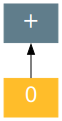

In [3]:
# tweak these as you like:
NUM_INPUT_UNITS = 100 # e.g. 4 Gaussians per leaf
NUM_SUM_UNITS   = 100   # e.g. 5 mixture components in the single SumLayer

net = define_circuit_one_sum(NUM_INPUT_UNITS, NUM_SUM_UNITS)

from cirkit.pipeline import PipelineContext
ctx = PipelineContext(backend="torch", semiring="sum-product", fold=False, optimize=False)
cc  = ctx.compile(net).cpu().eval()
# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {net.is_smooth}')
print(f'  - Decomposability: {net.is_decomposable}')
print(f'  - Structured-decomposability: {net.is_structured_decomposable}')
print(cc)
from cirkit.symbolic.io import plot_circuit
if plot_circuit is not None:
    dot = plot_circuit(net, orientation="vertical")
    display(dot)

In [4]:
import torch
from torch.distributions import Normal

# --- assume cc is your TorchCircuit instance ---
# e.g. cc = TorchCircuit(...)

# 1) Prepare inputs
input_vals = torch.tensor([[0.5], [1.0], [0.3]])  # shape (batch=3, vars=1)

# 2) Run the circuit
net_out = cc(input_vals)  # shape (3, 100)
net_out = net_out.squeeze(1) 
# 3) Extract the GaussianLayer and compute per-component PDFs
gi = cc.layers[0]  # TorchGaussianLayer

# raw parameters for mu and sigma
mu_node      = gi.mean._nodes[0]._ptensor            # shape (1, 200)
raw_sigma    = gi.stddev._nodes[0]._ptensor          # shape (1, 200)
sigma        = gi.stddev._nodes[1].forward(raw_sigma)# after sigmoid, shape (1, 200)

# expand to batch-size
# mu & sigma: (1,200) -> (3,200)
mu_exp   = mu_node.expand(input_vals.size(0), -1)
sigma_exp= sigma.expand(input_vals.size(0), -1)

# now compute each PDF for each output-unit i
# input_vals[:,0] is shape (3,), unsqueeze to (3,1) to broadcast against (3,200)
x = input_vals[:, 0].unsqueeze(1)  # (3,1)
normal = Normal(mu_exp, sigma_exp)
g_manual = normal.log_prob(x).exp()  # (3,200)

# 4) Extract the SumLayer weights and normalize
sl = cc.layers[1]  # TorchSumLayer
raw_w   = sl.weight._nodes[0]._ptensor       # shape (1,100,200)
w_norm  = sl.weight._nodes[1].forward(raw_w) # softmaxed along last dim, shape (1,100,200)
w_norm  = w_norm.squeeze(0)                  # (100,200)

# 5) Manually do the weighted sum: for each sample b and each output-unit j
#    y_manual[b,j] = sum_i g_manual[b,i] * w_norm[j,i]
#    g_manual: (3,200) -> (3,1,200), w_norm: (100,200) -> (1,100,200)
y_manual = (g_manual.unsqueeze(1) * w_norm.unsqueeze(0)).sum(-1)  # (3,100)
print(net_out.shape,y_manual.shape)
# print(net_out,y_manual)
# 6) Assert they match
assert torch.allclose(net_out, y_manual, atol=1e-6), "Mismatch between network and manual!"
print("✅ Manual calculation matches the circuit output.")


torch.Size([3, 100]) torch.Size([3, 100])
✅ Manual calculation matches the circuit output.


TorchCircuit(
  (0): TorchGaussianLayer(
    folds: 1  variables: 1  output-units: 10000
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 10000)
    (mean): TorchParameter(
      shape: (1, 10000)
      (0): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (1): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (2): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (3): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (4): TorchScaledSigmoidParameter(
        input-shapes: [(1, 100)]
        output-shape: (1, 100)
      )
      (5): TorchScaledSigmoidParameter(
        input-shapes: [(1, 100)]
        output-shape: (1, 100)
      )
      (6): 

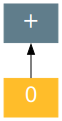

In [5]:
import cirkit.symbolic.functional as SF

# Construct the circuit computing Z, i.e., the integral of |c(X)|^2 over the complete domain of X
symbolic_circuit_partition_func = SF.multiply(net, net)
print(symbolic_circuit_partition_func)
print(ctx.compile(symbolic_circuit_partition_func))
plot_circuit(symbolic_circuit_partition_func)

In [13]:
import torch
from cirkit.backend.torch.parameters.nodes import TorchKroneckerParameter

# 1 Pick the device once
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

# 2 Create the re-parameterisation module on that device
p = TorchKroneckerParameter(
        in_shape1=(2, 3),
        in_shape2=(3, 2),
        num_folds=4,
).to(device)                     # move parameters/buffers to GPU

# 3 Generate inputs on the same device
x1 = torch.randn(4, 2, 3, device=device)
x2 = torch.randn(4, 3, 2, device=device)

# 4 Forward pass
y = p.forward(x1, x2)

# 5 Inspect shapes, devices and dtypes
def info(label, t):
    print(f"{label}: shape={tuple(t.shape)}, device={t.device}, dtype={t.dtype}")

info("x1", x1)
info("x2", x2)
info("y ", y)


Using cuda
x1: shape=(4, 2, 3), device=cuda:0, dtype=torch.float32
x2: shape=(4, 3, 2), device=cuda:0, dtype=torch.float32
y : shape=(4, 6, 6), device=cuda:0, dtype=torch.float32


In [1]:
"""
Experiment: Full Kronecker vs. basic Nyström approximation
----------------------------------------------------------
* Single tuning knob: `sizes` – list of matrix edge-lengths `s`
  – x1 : (s × s) , x2 : (s × s)         (non-symmetric weights)
  – y  : (s² × s²)  Kronecker product
* We time / measure peak GPU memory ONLY for the forward pass itself.
* After every timed section all GPU tensors are moved back to CPU
  and the cache is cleared, preventing GPU OOM.
"""

import time
import torch
from cirkit.backend.torch.parameters.nodes import TorchKroneckerParameter

# ──────────────────────────────────────────────────────────────────────────────
# helpers
# ──────────────────────────────────────────────────────────────────────────────
def kron_time_mem(p, x1_cpu, x2_cpu, device):
    """Move inputs to GPU, run forward once, immediately free memory."""
    torch.cuda.empty_cache()
    x1 = x1_cpu.to(device, non_blocking=True)
    x2 = x2_cpu.to(device, non_blocking=True)

    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize()
    t0 = time.perf_counter()

    y_gpu = p.forward(x1, x2)                 # <<< the only op we measure

    torch.cuda.synchronize()
    t_ms   = (time.perf_counter() - t0) * 1e3
    mem_mb = torch.cuda.max_memory_allocated(device) / 1e6

    y_cpu = y_gpu.cpu()                       # keep result for error calc
    del y_gpu, x1, x2
    torch.cuda.empty_cache()
    return y_cpu, t_ms, mem_mb


def nystrom_time_mem(A_cpu, c, device):
    """
    Very basic Nyström: one fold at a time on the GPU.
    Returns the CPU reconstruction and timing / peak-mem for the whole sweep.
    """
    folds, m, n = A_cpu.shape
    A_hat_cpu = torch.empty_like(A_cpu)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize()
    t0 = time.perf_counter()

    peak_mb = 0.0
    for f in range(folds):
        A_f = A_cpu[f].to(device, non_blocking=True)          # GPU copy
        idx = torch.randperm(n, device=device)[:c]
        C   = A_f[:, idx]                                     # (m, c)
        A_hat_f = C @ torch.linalg.pinv(C) @ A_f              # Nyström

        A_hat_cpu[f] = A_hat_f.cpu()                          # back to CPU
        peak_mb = max(peak_mb,
                      torch.cuda.max_memory_allocated(device) / 1e6)

        del A_f, C, A_hat_f
        torch.cuda.empty_cache()

    torch.cuda.synchronize()
    t_ms = (time.perf_counter() - t0) * 1e3
    return A_hat_cpu, t_ms, peak_mb


def rel_fro_error(A, A_hat):
    return (torch.linalg.norm(A - A_hat) /
            torch.linalg.norm(A)).item()


# ──────────────────────────────────────────────────────────────────────────────
# experiment configuration
# ──────────────────────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float32
folds  = 20

sizes  = [2, 4, 8, 16, 32, 64, 128, 180, 200]   # matrix edge lengths s
base_sample_counts = [4, 8, 16, 32, 64, 128, 180]

print(f"Running on {device}…\n")
print(f"{'size':>4} | {'c':>4} | "
      f"{'kron ms':>8} | {'kron MB':>8} | "
      f"{'nys ms':>8} | {'nys MB':>8} | "
      f"{'rel err':>8}")
print('-' * 64)

for s in sizes:
    # Build parameter on GPU (it is tiny)
    p = TorchKroneckerParameter(
            in_shape1=(s, s),
            in_shape2=(s, s),
            num_folds=folds
        ).to(device)

    # Inputs live on CPU until the exact moment we need them on GPU
    x1_cpu = torch.randn(folds, s, s, dtype=dtype)
    x2_cpu = torch.randn(folds, s, s, dtype=dtype)

    # Kronecker
    y_full_cpu, kron_ms, kron_mb = kron_time_mem(p, x1_cpu, x2_cpu, device)
    _, n = y_full_cpu.shape[-2:]                     # width for Nyström

    # Nyström sample budgets to test
    sample_counts = [c for c in base_sample_counts if c <= int(n/3)]
    if n not in sample_counts:
        sample_counts.append(n)                      # full rank baseline

    for c in sample_counts:
        y_hat_cpu, nys_ms, nys_mb = nystrom_time_mem(y_full_cpu, c, device)
        err = rel_fro_error(y_full_cpu, y_hat_cpu)

        print(f"{s:>4} | {c:>4} | "
              f"{kron_ms:8.2f} | {kron_mb:8.2f} | "
              f"{nys_ms:8.2f} | {nys_mb:8.2f} | "
              f"{err:8.4f}")


Running on cuda…

size |    c |  kron ms |  kron MB |   nys ms |   nys MB |  rel err
----------------------------------------------------------------
   2 |    4 |     8.33 |     0.00 |   152.96 |     8.53 |   0.0000
   4 |    4 |     0.14 |     8.54 |     9.54 |     8.53 |   0.6459
   4 |   16 |     0.14 |     8.54 |    10.99 |     8.53 |   0.0000
   8 |    4 |     0.10 |     8.86 |    17.93 |    11.69 |   0.8987
   8 |    8 |     0.10 |     8.86 |    14.97 |    11.69 |   0.7913
   8 |   16 |     0.10 |     8.86 |    17.94 |    11.70 |   0.6321
   8 |   64 |     0.10 |     8.86 |    29.19 |     8.66 |   0.0000
  16 |    4 |     0.11 |    13.80 |    15.21 |    11.94 |   0.9706
  16 |    8 |     0.11 |    13.80 |    17.43 |    11.96 |   0.9418
  16 |   16 |     0.11 |    13.80 |    19.01 |    11.98 |   0.8907
  16 |   32 |     0.11 |    13.80 |    22.34 |    12.03 |   0.7905
  16 |   64 |     0.11 |    13.80 |    41.32 |    12.15 |   0.6118
  16 |  256 |     0.11 |    13.80 |   151.50 |

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 GiB. GPU 0 has a total capacity of 11.59 GiB of which 10.24 GiB is free. Of the allocated memory 10.62 MiB is allocated by PyTorch, and 9.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)